In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [84]:
class Net(nn.Module):
  def __init__(self, input_size, num_classes):
    dropout_value = 0.1
    super(Net, self).__init__()
    self.convblock1 =  nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) #26x26

    self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) #24x24


    self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) #22x22

    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #11x11

    self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) #9x9

    self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) #7x7

    self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) #5x5

    #self.fc = nn.Linear(in_features=4*4*8, out_features=10)
    self.gap = nn.AvgPool2d(kernel_size=5)

  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = self.pool1(x)

    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.gap(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)

In [70]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(input_size=28, num_classes=10)
model.to(device)
summary(model, input_size=(1, 28, 28))

False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             

/tmp/ipython-input-3012678222.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [77]:
torch.manual_seed(1)
batch_size=128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Train Phase transformations
train_transforms = transforms.Compose([
                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                       transforms.RandomAffine(degrees=0, shear=15),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

# Test Phase transformations
test_transforms = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])


train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

if use_cuda:
  dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
else:
  dataloader_args = dict(shuffle=True, batch_size=batch_size//2)


train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


In [78]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch, scheduler=None):
  model.train()
  pbar = tqdm(train_loader)
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if scheduler is not None:
        scheduler.step()
    train_losses.append(loss.item())
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum().item()
    processed = len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_acc.append(100. * correct / len(test_loader.dataset))


  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [73]:
!pip install torch_lr_finder

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipython-input-3012678222.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.90E-01


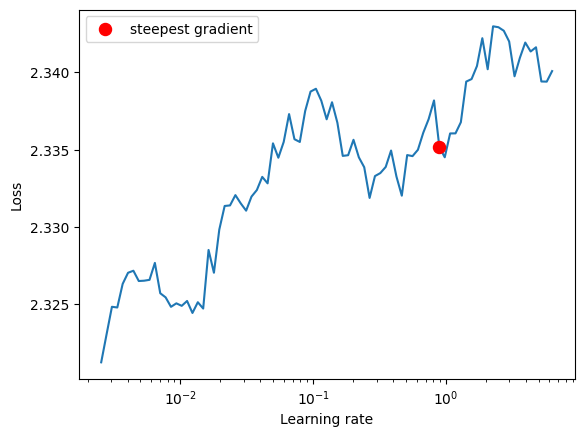

In [79]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

from torch_lr_finder import LRFinder
model = Net(28, 10).to(device)

lr_finder = LRFinder(model, optimizer, criterion=criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode="exp")
lr_finder.plot()  # to visualize the loss vs. learning rate
lr_finder.reset() # to restore the model and optimizer to their initial state


In [80]:
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=8.90E-01, steps_per_epoch=len(train_loader),
                                          epochs=15, pct_start=0.3, anneal_strategy='cos',div_factor=25)

for epoch in range(15):
  print(epoch)
  train(model, device, train_loader, optimizer, epoch, scheduler)
  test(model, device, test_loader)

0


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipython-input-3012678222.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=0.09126799553632736 Batch_id=937 Accuracy=100.00: 100%|██████████| 938/938 [01:23<00:00, 11.26it/s]



Test set: Average loss: 0.0869, Accuracy: 9716/10000 (97.16%)

1


Loss=0.034086838364601135 Batch_id=937 Accuracy=100.00: 100%|██████████| 938/938 [01:19<00:00, 11.74it/s]



Test set: Average loss: 0.0580, Accuracy: 9824/10000 (98.24%)

2


Loss=0.16904595494270325 Batch_id=937 Accuracy=96.88: 100%|██████████| 938/938 [01:20<00:00, 11.59it/s]



Test set: Average loss: 0.0389, Accuracy: 9880/10000 (98.80%)

3


Loss=0.04138818383216858 Batch_id=937 Accuracy=96.88: 100%|██████████| 938/938 [01:19<00:00, 11.75it/s]



Test set: Average loss: 0.0526, Accuracy: 9837/10000 (98.37%)

4


Loss=0.05349741131067276 Batch_id=937 Accuracy=96.88: 100%|██████████| 938/938 [01:20<00:00, 11.63it/s]



Test set: Average loss: 0.0255, Accuracy: 9922/10000 (99.22%)

5


Loss=0.04489636793732643 Batch_id=937 Accuracy=96.88: 100%|██████████| 938/938 [01:19<00:00, 11.80it/s]



Test set: Average loss: 0.0312, Accuracy: 9895/10000 (98.95%)

6


Loss=0.06259212642908096 Batch_id=937 Accuracy=96.88: 100%|██████████| 938/938 [01:23<00:00, 11.17it/s]



Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

7


Loss=0.28087368607521057 Batch_id=937 Accuracy=93.75: 100%|██████████| 938/938 [01:23<00:00, 11.25it/s]



Test set: Average loss: 0.0229, Accuracy: 9921/10000 (99.21%)

8


Loss=0.019794035702943802 Batch_id=937 Accuracy=100.00: 100%|██████████| 938/938 [01:19<00:00, 11.75it/s]



Test set: Average loss: 0.0234, Accuracy: 9933/10000 (99.33%)

9


Loss=0.00441579008474946 Batch_id=937 Accuracy=100.00: 100%|██████████| 938/938 [01:18<00:00, 12.02it/s]



Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

10


Loss=0.07189474999904633 Batch_id=937 Accuracy=96.88: 100%|██████████| 938/938 [01:18<00:00, 12.02it/s]



Test set: Average loss: 0.0231, Accuracy: 9935/10000 (99.35%)

11


Loss=0.22912481427192688 Batch_id=937 Accuracy=96.88: 100%|██████████| 938/938 [01:18<00:00, 11.91it/s]



Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

12


Loss=0.03692250698804855 Batch_id=937 Accuracy=96.88: 100%|██████████| 938/938 [01:25<00:00, 11.03it/s]



Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

13


Loss=0.07090017944574356 Batch_id=937 Accuracy=96.88: 100%|██████████| 938/938 [01:23<00:00, 11.25it/s]



Test set: Average loss: 0.0178, Accuracy: 9945/10000 (99.45%)

14


Loss=0.004634966608136892 Batch_id=937 Accuracy=100.00: 100%|██████████| 938/938 [01:21<00:00, 11.52it/s]



Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)



Text(0.5, 1.0, 'Test Accuracy')

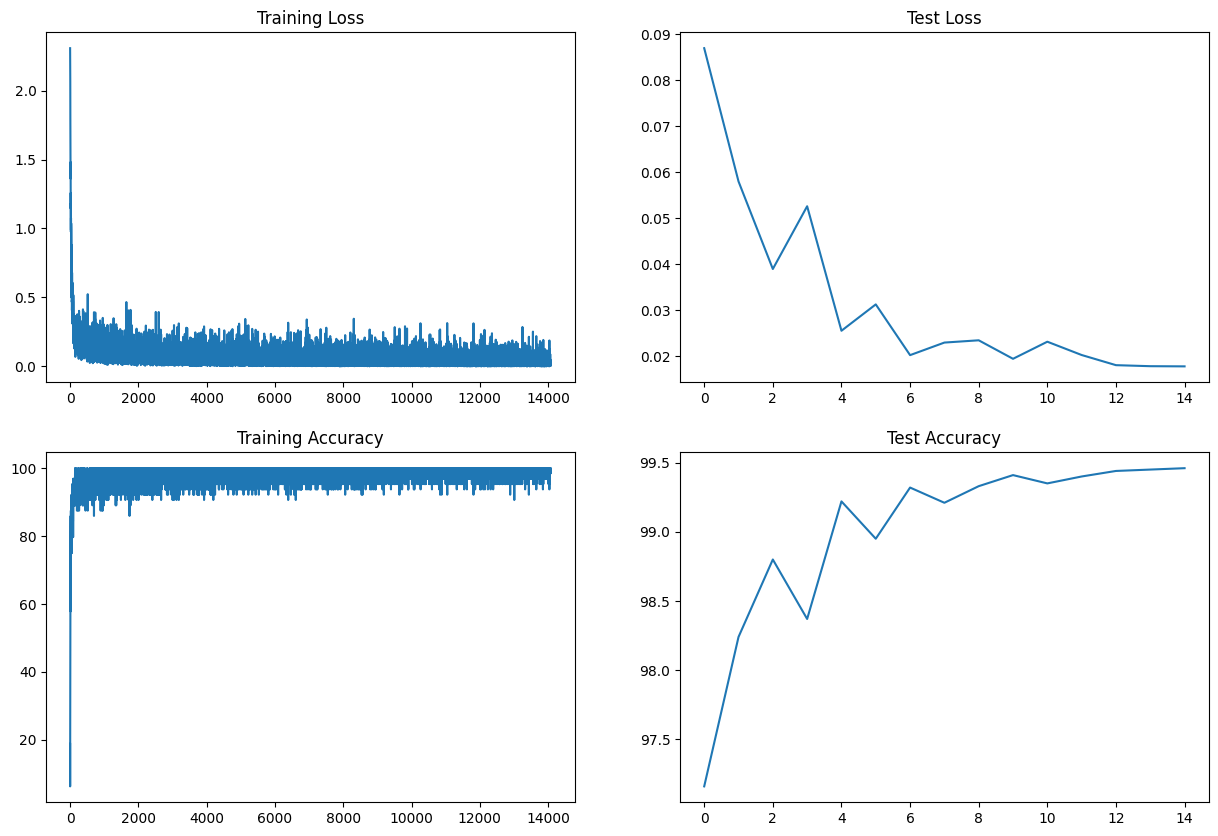

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")